<a href="https://colab.research.google.com/github/talhaanwarch/skin-disease-diagnosis/blob/master/Scenario_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scenario II:** Training on ISIC 2019 and tested on PAD dataset (Only images)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp /content/drive/My\ Drive/isic_weights/isicall_eff3_weights.hdf5 /content/

In [3]:
%%capture
!pip install efficientnet

In [4]:
#download the dataset
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip

--2020-08-27 15:36:02--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.187
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.97.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘zr7vgbcyr2-1.zip’

zr7vgbcyr2-1.zip    100%[===================>]   3.35G  20.9MB/s    in 2m 45s  

2020-08-27 15:38:48 (20.7 MB/s) - ‘zr7vgbcyr2-1.zip’ saved [3593344681/3593344681]



In [5]:
#unzip the dataset
%%capture
!unzip zr7vgbcyr2-1.zip

In [6]:
#create a new folder named as data
!mkdir data

In [7]:
#unzip all subfolder
%%capture
!unzip /content/images/imgs_part_1.zip
!unzip /content/images/imgs_part_2.zip
!unzip /content/images/imgs_part_3.zip

In [8]:
#move all pictures from subfolder to main folder data
!mv  /content/imgs_part_1/* /content/data
!mv  /content/imgs_part_2/* /content/data
!mv  /content/imgs_part_3/* /content/data

In [9]:
#remove the folder that contain subfolders
!rm -r /content/images

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#read annotation file
df=pd.read_csv('/content/metadata.csv')
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [11]:
#shuffle the dataframe
df=df.sample(frac=1)
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
284,PAT_1071,313,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,False,False,False,False,False,False,PAT_1071_313_789.png,False
643,PAT_412,817,False,False,POMERANIA,POMERANIA,46,True,MALE,False,True,False,True,2.0,FACE,10.0,9.0,BCC,False,True,False,False,False,True,PAT_412_817_232.png,True
546,PAT_517,972,False,False,POMERANIA,POMERANIA,94,False,FEMALE,True,True,True,True,2.0,NOSE,8.0,7.0,BCC,True,UNK,True,UNK,True,True,PAT_517_972_845.png,True
2194,PAT_191,293,True,False,POMERANIA,POMERANIA,85,False,FEMALE,False,True,True,True,2.0,ARM,15.0,10.0,BCC,True,True,True,False,True,True,PAT_191_293_699.png,True
1208,PAT_1412,1421,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1412_1421_512.png,False


In [12]:
#create a dataframe with image name and encoded labels
labels=pd.get_dummies(df['diagnostic'])
df_img=pd.concat([df['img_id'],labels],axis=1)
df_img.head()
#MEL	NV	BCC	AK	BKL		SCC

,img_id,ACK,BCC,MEL,NEV,SCC,SEK
284,PAT_1071_313_789.png,1,0,0,0,0,0
643,PAT_412_817_232.png,0,1,0,0,0,0
546,PAT_517_972_845.png,0,1,0,0,0,0
2194,PAT_191_293_699.png,0,1,0,0,0,0
1208,PAT_1412_1421_512.png,1,0,0,0,0,0


In [13]:
#labels columns in dataframe
col=list(df_img.columns)[1::]
col

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [14]:
df['smoke']=df['smoke'].fillna('unknown').astype('str')
df['drink']=df['drink'].fillna('unknown').astype('str')
df['pesticide']=df['pesticide'].fillna('unknown').astype('str')
df['gender']=df['gender'].fillna('unknown').astype('str')
df['skin_cancer_history']=df['skin_cancer_history'].fillna('unknown').astype('str')
df['cancer_history']=df['cancer_history'].fillna('unknown').astype('str')
df['has_piped_water']=df['has_piped_water'].fillna('unknown').astype('str')
df['has_sewage_system']=df['has_sewage_system'].fillna('unknown').astype('str')

df['fitspatrick']=df['fitspatrick'].fillna('unknown').astype('str')
df['has_sewage_system']=df['has_sewage_system'].fillna('unknown').astype('str')
df['diameter_1'].fillna(df['diameter_1'].mean(),inplace=True)
df['diameter_2'].fillna(df['diameter_2'].mean(),inplace=True)

In [15]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
encLE=LabelEncoder()
encOHE=OneHotEncoder(sparse=False)

In [16]:
for i in df.columns[2::]:
  if i!='diagnostic' or i!='img_id':
    df[i]=encLE.fit_transform(df[i].astype('str'))

In [17]:
tab_features=df.drop(['patient_id','lesion_id','diagnostic','img_id'],axis=1)
tab_labels=df['diagnostic']
tab_features.head()

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,biopsed
284,2,2,13,11,42,2,2,2,2,2,2,6,5,6,37,0,0,0,0,0,0,0
643,0,0,9,7,33,1,1,0,1,0,1,1,5,3,38,0,1,0,0,0,1,1
546,0,0,9,7,83,0,0,1,1,1,1,1,11,39,34,1,2,1,2,1,1,1
2194,1,0,9,7,74,0,0,0,1,1,1,1,1,10,3,1,1,1,0,1,1,1
1208,2,2,13,11,63,2,2,2,2,2,2,6,8,6,37,1,0,0,0,0,0,0


In [18]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest')

In [19]:
# model hyperparameters
img_shape=300
batch_size=20
n_epochs=20

In [23]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [20]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)

In [21]:
def basemodel():
  import efficientnet.tfkeras as efn
  pre_trained_model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
  x = pre_trained_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation="relu")(x)
  predictions = Dense(8, activation="softmax")(x) #pretrained model has 7 classes
  pre_trained_model = Model(inputs=pre_trained_model.input, outputs=predictions)
  pre_trained_model.load_weights('/content/isicall_eff3_weights.hdf5') #load pretrained weights to to model
  #now remove all added layers in pretrained layers add new leayer and create base model
  #here we can test how many layers we want to remove
  base_model = Model(pre_trained_model.input, pre_trained_model.layers[-7].output)
  #now add our new layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128,name='dense1', activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64,name='dense2', activation="relu")(x)

  predictions  = Dense(len(col),name='output', activation="softmax")(x) #base model has six layers
  base_model = Model(inputs=base_model.input, outputs=predictions )
  #compile the base model
  base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return base_model

In [55]:

from sklearn.model_selection import KFold,StratifiedKFold
import gc

from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
classification_reports=[]
kf = KFold(n_splits=5,shuffle=True)
history=[]
accuracy=[]
f1_scores=[]
auc=[]
y_pred=[]
precision=[]
recall=[]
fold=0
for train_index, test_index in kf.split(df_img):
  train=df_img.iloc[train_index,:]
  val=df_img.iloc[test_index,:]
  print('-----------fold {}--------------'.format(fold))
  train_generator=data_gen.flow_from_dataframe(train,directory='/content/data',
                                               target_size=(img_shape,img_shape),
                                               x_col='img_id',
                                               y_col=col,
                                               class_mode='raw',
                                               shuffle=True,
                                               batch_size=batch_size)

  val_generator=data_gen.flow_from_dataframe(val,directory='/content/data',
                                             target_size=(img_shape,img_shape),
                                             x_col="img_id",
                                             y_col=col,
                                             class_mode='raw',
                                             shuffle=False,
                                             batch_size=batch_size)
  #train_generator.next()[0].shape,train_generator.next()[1].shape

  #load base model
  base_model=basemodel()
  #train model
  results = base_model.fit(train_generator,epochs=25,verbose=1,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.000001),
                                         #ModelCheckpoint('model_{}.hdf5'.format(fold), save_best_only=True, monitor='val_loss', mode='min')
                                         ])
  y_true=val.iloc[:,1::]
  val_generator.reset()
  img_pred=base_model.predict(val_generator,steps=val_generator.n/batch_size,verbose=0)

  xgb_clf.fit(tab_features.values[train_index,:],tab_labels.iloc[train_index],verbose=False)
  tab_pred=xgb_clf.predict_proba(tab_features.values[test_index,:])

  tab_f1=f1_score(y_true,tab_pred.round().astype(int),average='macro',labels=np.unique(tab_pred))
  img_f1=f1_score(y_true,img_pred.round().astype(int),average='macro',labels=np.unique(img_pred))
  print('f1 score is ', img_f1,' and ',tab_f1)

  wt=tab_f1+img_f1
  y_pred=((tab_f1/wt)*tab_pred)+((img_f1/wt)*img_pred)
  y_pred=np.round(y_pred,0)
  accuracy.append(accuracy_score(y_true,y_pred))
  auc.append(roc_auc_score(y_true,y_pred))
  precision.append(precision_score(y_true,y_pred,average='macro',labels=np.unique(y_pred)))
  recall.append(recall_score(y_true,y_pred,average='macro',labels=np.unique(y_pred)))
  f1_scores.append(f1_score(y_true,y_pred,average='macro',labels=np.unique(y_pred)))
  history.append(results)
  fold+=1

  del base_model
  K.clear_session()
  gc.collect()

-----------fold 0--------------
Found 1838 validated image filenames.
Found 460 validated image filenames.
Epoch 1/25
92/91 [==============================] - 157s 2s/step - loss: 1.1651 - accuracy: 0.5724 - val_loss: 1.1149 - val_accuracy: 0.6239
Epoch 2/25
92/91 [==============================] - 154s 2s/step - loss: 0.8823 - accuracy: 0.6915 - val_loss: 2.3709 - val_accuracy: 0.6152
Epoch 3/25
92/91 [==============================] - 155s 2s/step - loss: 0.8005 - accuracy: 0.7182 - val_loss: 1.5916 - val_accuracy: 0.6457
Epoch 4/25
92/91 [==============================] - 154s 2s/step - loss: 0.7204 - accuracy: 0.7405 - val_loss: 0.8858 - val_accuracy: 0.6609
Epoch 5/25
92/91 [==============================] - 154s 2s/step - loss: 0.6894 - accuracy: 0.7612 - val_loss: 0.9423 - val_accuracy: 0.7109
Epoch 6/25
92/91 [==============================] - 154s 2s/step - loss: 0.6393 - accuracy: 0.7726 - val_loss: 0.8038 - val_accuracy: 0.7000
Epoch 7/25
92/91 [=============================

In [56]:
#average accuracy across all folds
np.mean(accuracy)

0.7806782229800133

In [57]:
#average precision across all folds
np.mean(precision)

0.896752989269937

In [58]:
#average recall across all folds
np.mean(recall)

0.86161435101272

In [59]:
#average f1_scores across all folds
np.mean(f1_scores)

0.8774669645863469

In [60]:
#average auc_scores across all folds
np.mean(auc)

0.8165380121888683

In [61]:
history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [62]:
def plot_accuracy(hist,acc='val_accuracy'):
    for i in range(5):
      plt.plot(hist[i].history[acc],linestyle='-.',linewidth=1.5)
     
    mean=np.mean([[j for j in x.history[acc]] for x in hist],axis=0)
    std=np.std([[j for j in x.history[acc]] for x in hist],axis=0)
    plt.plot(mean,linewidth=2,color='black')
    if acc=='val_accuracy':
      plt.title('Model Validation Accuracy')
    else:
      plt.title('Model Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Fold1','Fold2','Fold3','Fold4','Fold5','Average Val Accuracy' ], loc='best')
    plt.show()

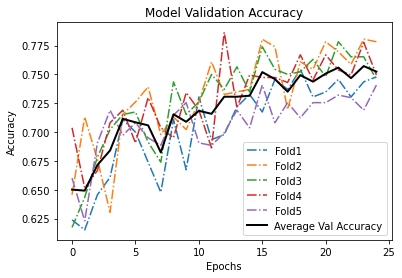

In [63]:
plot_accuracy(history)

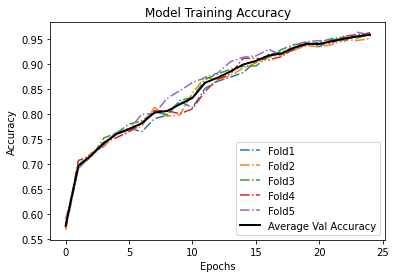

In [64]:
plot_accuracy(history,acc='accuracy')